In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [2]:
print(os.getcwd())

/Users/lm2612/Documents/PhD/DeepLearning/coursework/dl-imperial-maths/assignments/week_2


In [3]:
mnist_dir = 'mnist/'
train = mnist_dir+'t10k-images.idx3-ubyte'

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
input_data.read_data_sets

<function tensorflow.contrib.learn.python.learn.datasets.mnist.read_data_sets(train_dir, fake_data=False, one_hot=False, dtype=tf.float32, reshape=True, validation_size=5000, seed=None, source_url='https://storage.googleapis.com/cvdf-datasets/mnist/')>

In [5]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [6]:
training_images = mnist.train.images
training_labels = mnist.train.labels
test_images = mnist.test.images
test_labels = mnist.test.labels
validation_images = mnist.validation.images
validation_labels = mnist.validation.labels

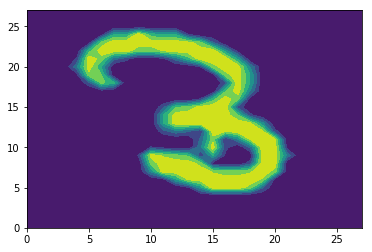

In [7]:
example = training_images[1,:]
example = np.reshape(example,(28,28))
plt.contourf(example)

In [8]:
class mlp_classifier():
    """ multilayer perceptron classifer designed classifying the mnist dataset
    takes in images and classifies the label"""
    def __init__(self,wd_factor=0.0001,learning_rate=0.0001,
                 n_layers=5,nodes_per_layer=[392,196,98,49]):
        self.wd_factor = wd_factor
        self.learning_rate = learning_rate
        self.n_layers = n_layers
        self.nodes_per_layer = nodes_per_layer
        #assert (n_layers==len(nodes_per_layer))
        self.sess = tf.Session()
        # set placeholders for our data
        self.image = tf.placeholder(dtype=tf.float32, shape=[None, 784], name='image')
        self.true_label = tf.placeholder(dtype=tf.float32,shape=[None,10],name='label')
        self._build_graph()
        
        self.train_pointer = 0
        self.test_pointer = 0
        
        
    def _build_graph(self):   
        n_layers = self.n_layers
        nodes_per_layer = self.nodes_per_layer
        print('Building graph with {} layers, with {} nodes '.format(n_layers,nodes_per_layer))
        with tf.variable_scope('layers'):
            h = tf.layers.dense(self.image, nodes_per_layer[0], 
                                kernel_initializer=tf.glorot_uniform_initializer(), 
                                activation=tf.tanh, name='1',reuse=tf.AUTO_REUSE)
            print(h)
            # Loop over all layers specified
            for i in range(1,n_layers-1):    
                h = tf.layers.dense(h, nodes_per_layer[i], 
                                    kernel_initializer=tf.glorot_uniform_initializer(), 
                                activation=tf.tanh, name=str(i+1),reuse=tf.AUTO_REUSE)
                print(h)
            
            # our final layer with 10 logits
            self.logits = tf.layers.dense(h, 10, 
                                          kernel_initializer=tf.glorot_uniform_initializer(), 
                                          activation=tf.identity, name=str(n_layers),reuse=tf.AUTO_REUSE)
            print(self.logits)
            self.prediction = tf.nn.softmax(self.logits, name='softmax_prediction')
            
        with tf.name_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, 
                                                                                  labels=self.true_label))
            self.loss += self.weight_decay()
            
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.train_op = self.optimizer.minimize(self.loss)
        
    def weight_decay(self):
        loss = 0
        for v in tf.global_variables():
            if 'Adam' in v.name:
                continue
            elif 'kernel' in v.name:
                loss += self.wd_factor * tf.nn.l2_loss(v)
        print(loss)
        return loss
        
    def train_minibatch(self, samples, labels, batch_size):
        if self.train_pointer + batch_size <= samples.shape[0]:
            samples_minibatch = samples[self.train_pointer: self.train_pointer + batch_size]
            labels_minibatch = labels[self.train_pointer: self.train_pointer + batch_size]
            self.train_pointer += batch_size
        else:
            samples_minibatch = samples[self.train_pointer:]
            labels_minibatch = labels[self.train_pointer: self.train_pointer + batch_size]
            self.train_pointer = 0
        return samples_minibatch, labels_minibatch

    def train(self, train_samples, train_labels, train_batch_size, iteration_steps):
        self.sess.run(tf.global_variables_initializer())

        print('Start Training')
        losses = []
        for i in range(iteration_steps):
            samples, labels = self.train_minibatch(train_samples, train_labels, train_batch_size)
            feed_dict = {self.image: samples, self.true_label: labels}
            _, loss = self.sess.run([self.train_op, self.loss], feed_dict=feed_dict)
            if i % 50 == 0:
                print("Minibatch loss at step {}: {}".format(i, loss))
                losses.append([i, loss])
        return losses
                    
    def test_minibatch(self, samples, labels, batch_size):
        if self.test_pointer + batch_size <= samples.shape[0]:
            samples_minibatch = samples[self.test_pointer: self.test_pointer + batch_size]
            labels_minibatch = labels[self.test_pointer: self.test_pointer + batch_size]
            self.test_pointer += batch_size
            end_of_epoch = False
        else:
            samples_minibatch = samples[self.test_pointer:]
            labels_minibatch = labels[self.test_pointer: self.test_pointer + batch_size]
            self.test_pointer = 0
            end_of_epoch = True
        return samples_minibatch, labels_minibatch, end_of_epoch
            
    def test(self, test_samples, test_labels, test_batch_size):
        end_of_epoch = False
        losses = []
        while not end_of_epoch:
            samples, labels, end_of_epoch = self.test_minibatch(test_samples, test_labels, test_batch_size)
            feed_dict = {self.image: samples, self.true_label: labels}
            loss_value = self.sess.run(self.loss, feed_dict=feed_dict)
            losses.append(loss_value)  
        print("Average test loss: {}".format(np.mean(losses)))
        

In [9]:
model = mlp_classifier()
print(tf.global_variables())


Building graph with 5 layers, with [392, 196, 98, 49] nodes 
Tensor("layers/1/Tanh:0", shape=(?, 392), dtype=float32)
Tensor("layers/2/Tanh:0", shape=(?, 196), dtype=float32)
Tensor("layers/3/Tanh:0", shape=(?, 98), dtype=float32)
Tensor("layers/4/Tanh:0", shape=(?, 49), dtype=float32)
Tensor("layers/5/Identity:0", shape=(?, 10), dtype=float32)
Tensor("loss/add_4:0", shape=(), dtype=float32)
[<tf.Variable 'layers/1/kernel:0' shape=(784, 392) dtype=float32_ref>, <tf.Variable 'layers/1/bias:0' shape=(392,) dtype=float32_ref>, <tf.Variable 'layers/2/kernel:0' shape=(392, 196) dtype=float32_ref>, <tf.Variable 'layers/2/bias:0' shape=(196,) dtype=float32_ref>, <tf.Variable 'layers/3/kernel:0' shape=(196, 98) dtype=float32_ref>, <tf.Variable 'layers/3/bias:0' shape=(98,) dtype=float32_ref>, <tf.Variable 'layers/4/kernel:0' shape=(98, 49) dtype=float32_ref>, <tf.Variable 'layers/4/bias:0' shape=(49,) dtype=float32_ref>, <tf.Variable 'layers/5/kernel:0' shape=(49, 10) dtype=float32_ref>, <tf.V

In [10]:
TRAIN_BATCH_SIZE = 128
ITERATIONS = 10000

In [11]:
import time
start_time = time.time()

losses = model.train(training_images, training_labels, TRAIN_BATCH_SIZE, ITERATIONS)

end_time = time.time()
print("Training time: {}s".format(end_time - start_time))

Start Training
Minibatch loss at step 0: 2.3698549270629883
Minibatch loss at step 50: 1.0555980205535889
Minibatch loss at step 100: 0.9189651608467102
Minibatch loss at step 150: 0.7846083641052246
Minibatch loss at step 200: 0.7380711436271667
Minibatch loss at step 250: 0.5806199312210083
Minibatch loss at step 300: 0.4004376232624054
Minibatch loss at step 350: 0.6250846982002258
Minibatch loss at step 400: 0.4929211437702179
Minibatch loss at step 450: 0.398990273475647
Minibatch loss at step 500: 0.5732243061065674
Minibatch loss at step 550: 0.2662261724472046
Minibatch loss at step 600: 0.3713781535625458
Minibatch loss at step 650: 0.3083410859107971
Minibatch loss at step 700: 0.3420518636703491
Minibatch loss at step 750: 0.36967864632606506
Minibatch loss at step 800: 0.2769264280796051
Minibatch loss at step 850: 0.3058347702026367
Minibatch loss at step 900: 0.32705920934677124
Minibatch loss at step 950: 0.3534393310546875
Minibatch loss at step 1000: 0.1993301063776016

Minibatch loss at step 8450: 0.06805247068405151
Minibatch loss at step 8500: 0.14136841893196106
Minibatch loss at step 8550: 0.08872969448566437
Minibatch loss at step 8600: 0.12604032456874847
Minibatch loss at step 8650: 0.057283733040094376
Minibatch loss at step 8700: 0.07018151134252548
Minibatch loss at step 8750: 0.08326907455921173
Minibatch loss at step 8800: 0.06798677891492844
Minibatch loss at step 8850: 0.11206655204296112
Minibatch loss at step 8900: 0.0631711483001709
Minibatch loss at step 8950: 0.09288255125284195
Minibatch loss at step 9000: 0.08069358766078949
Minibatch loss at step 9050: 0.07793664932250977
Minibatch loss at step 9100: 0.08078113198280334
Minibatch loss at step 9150: 0.05390135198831558
Minibatch loss at step 9200: 0.09716109931468964
Minibatch loss at step 9250: 0.056534312665462494
Minibatch loss at step 9300: 0.07547704875469208
Minibatch loss at step 9350: 0.100806325674057
Minibatch loss at step 9400: 0.060509972274303436
Minibatch loss at st

(200, 2)


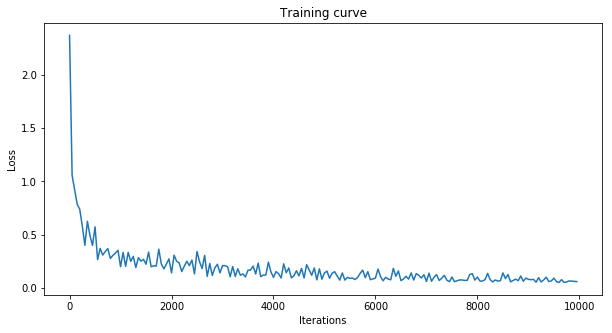

In [20]:
losses = np.array(losses)
print(losses.shape)
import matplotlib.pyplot as plt

iterations = losses[:, 0]
train_loss = losses[:, 1]
plt.figure(figsize=(10, 5))
plt.plot(iterations, train_loss)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training curve")
plt.show()

In [22]:
TEST_BATCH_SIZE = 128
model.test(test_images, test_labels, TEST_BATCH_SIZE)

Average test loss: 0.11391542851924896


In [28]:
test_images.shape

(10000, 784)

Test sample digit: 7


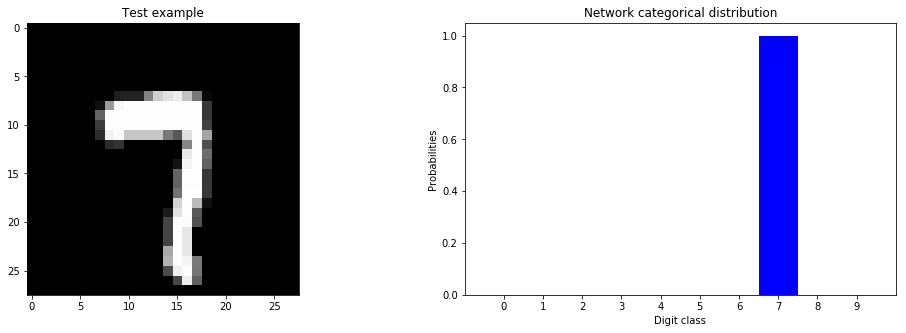

Network prediction probabilities:
[1.4949508e-05 5.0532122e-05 1.9854722e-04 2.3991475e-04 6.6208727e-06
 9.4807792e-06 9.4892904e-08 9.9892682e-01 1.0495617e-05 5.4253987e-04]


In [44]:
n_test = test_images.shape[0]
example = np.random.choice(np.arange(n_test))

sample = np.expand_dims(test_images[example], axis=0)
label = np.expand_dims(test_labels[example], axis=0)

digit = np.where(label[0]==1.0)[0][0]

feed_dict = {model.image: sample, model.true_label: label}
prediction = model.sess.run(model.prediction, feed_dict=feed_dict)[0]

image = np.reshape(sample, (28, 28))


print("Test sample digit: {}".format(digit))
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Test example")

classes = np.arange(10)
width = 1.0

ax[1].bar(classes, prediction, width, color='Blue')
ax[1].set_ylabel('Probabilities')
ax[1].set_title('Network categorical distribution')
ax[1].set_xticks(classes)
ax[1].set_xticklabels(('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'))
ax[1].set_xlabel('Digit class')

plt.show()

print("Network prediction probabilities:")
print(prediction)